/////////////////////////////////////////////////////////////////////////////////////

                 LAB 1                     
/////////////////////////////////////////////////////////////////////////////////////


              Introduction : 
This lab is around using Kalman Filter for an object tracking in 2D space. The Kalman Filter is a work-horse in the field of robotics and control systems allowing to optimally estimate system states even with noisy measurements.

we have  pieced together the Kalman Filter and the Kalman Smoother for both of their causual forms (which is typically what's done in real-time position tracking) to see how much better we could do.

              Objectives

•  Simulate Data: Create continuous and discrete-time models of the object's position and velocity for Kalman Filter application.

•  Implement Causal Kalman Filter: Estimate position using only current and past data, and visualize performance over time.

•  Implement Kalman Smoother: Use future measurements to enhance estimation accuracy, comparing causal and smoothed results.

•  Analyze Performance: Plot and interpret results to assess accuracy and stability across filter types.


             Problem 1 : Discrete time model

### Problem 1.1: Calculate both matrixis  "A" and "C" : 

In [92]:
import numpy as np                ## import the necessary libraries 
import matplotlib.pyplot as plt   ## this library is used to plot the figures

In this Part we can calculate the  2 matrixes desired 

In [93]:
Ts = 0.1                          # Sampling Time
A = np.array([[1, 0, Ts, 0], 
              [0, 1, 0, Ts],
              [0, 0, 1, 0], 
              [0, 0, 0, 1]]) # State transition matrix
    
C = np.array([[1, 0, 0, 0],  [0, 1, 0, 0]])
    

### Problem 1.2: Calculate the covariance matrix of the process noise

In [94]:
# define system noise covariance and measurement noise covariance matrices
Ts = 0.1
q = ([[4/3*pow(Ts, 3), 0, 2*pow(Ts, 2), 0],
      [0, 4/3*pow(Ts, 3), 0, 2*pow(Ts, 2)],
      [2*pow(Ts, 2), 0, 4*Ts, 0],
      [0, 2*pow(Ts, 2), 0, 4*Ts]])

            Problem 2 : Data Simulation and Basic Analysis

### Problem 2.1: Calculate the covariance matrix of the process noise

in this part we have to calculate the  lower triangular matrix " L " using Cholesky decomposition

In [95]:
cov_m = np.array([[2, -1], [-1, 2]]) # covariance matrix
v = np.linalg.cholesky(cov_m).T      # Cholesky decomposition
print(v)

[[ 1.41421356 -0.70710678]
 [ 0.          1.22474487]]


In [96]:
r = ([[4, 0],
      [0, 4]])
# the initial condition x0 which is a Gaussian process with the
# mean m0, and the covariance matrix P0
m_0 = np.transpose([0, 0, 1, -1])

P_0 = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])


### Problem 2.2. Discrete time model


Application of the Kalman-Filter 

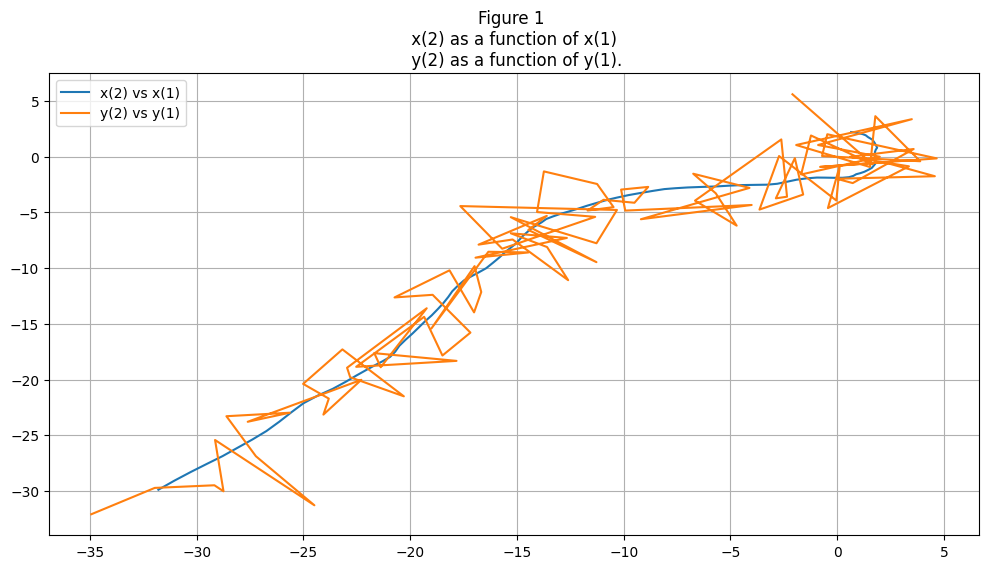

In [97]:
N = 100                         # The simulation time is N = 100 steps.
x_kalman = np.zeros((N, 4))     # Kalman filter state estimates
x_traj = np.zeros((N, 4))       # initialization of true state trajectory
y = np.zeros((N, 2))            # measurements
v = np.zeros((N, 2))            # measurement velocities


P_kalman = [P_0]                # the generation of x0 the initial condition which is gaussian
x_0 = np.random.multivariate_normal(m_0, P_0)

# initialize pk
pk = np.zeros((N, 4))        # diagonal elements of P_kk
psmooth = np.zeros((N, 4))   # smoothed estimates of state mean and covariance

# Kalman filter
# initial state estimate
x_kk = x_0
P_kk = P_0      # initial state covariance
x_kalman[0] = x_0
P_kalman[0] = P_0

# Generation of the discrete time model
for i in range(N):
    if i == 0:
        # For the first time step, set true state to initial state estimate
        # Generate measurements y and set state estimate to initial state estimate
        # Initialize pk to the first diagonal element of P_kk that will be used after
        x_traj[i] = x_0         # set true state to initial state estimate
        y[i] = (C @ x_traj[0].T) + np.random.multivariate_normal(np.zeros(2), r)
        x_kk = x_0              # set state estimate to initial state estimate
        P_kk = P_0
        pk[i] = P_kk[0, 0]      # initialing the storage of the elements of the diagonal matrix

    else:
        # discrete time model for the range
        x_traj[i] = (A @ x_traj[i - 1].T) + np.random.multivariate_normal(np.zeros(4), q)
        y[i] = (C @ x_traj[i].T) + np.random.multivariate_normal(np.zeros(2), r)
        v[i] = (y[i] - y[i - 1]) / Ts      # the speed by approximating the derivative with the Euler method

        # The prediction step, where the next state of the system is predicted
        # given the previous measurements.
        x_kk_1 = A @ x_kk
        P_kk_1 = A @ P_kk @ A.T + q

        # The correction step, where the current state of the system is estimated
        # given the measurement at that time step.
        K = P_kk_1 @ C.T @ np.linalg.inv(C @ P_kk_1 @ C.T + r)
        x_kk = x_kk_1 + K @ (y[i] - C @ x_kk_1)
        P_kk = (np.eye(4) - K @ C) @ P_kk_1

        # Update state and error covariance matrix
        x_kalman[i] = x_kk
        P_kalman.append(P_kk)

        # extract diagonal elements of P_kk
        pk = np.diagonal(P_kk)


###############################################################################
#     plotting of x(2) as a function of x(1) and y(2) as a function of y(1)   #
###############################################################################


fig, axs = plt.subplots(1, figsize=(12, 6))                                         # Create a figure and a single subplot with a specified size
x_1 = x_traj[:, 0]                                                                  # Extract the first column (x(1)) from x_traj for plotting
x_2 = x_traj[:, 1]                                                                  # Extract the second column (x(2)) from x_traj for plotting
axs.plot(x_1, x_2, label='x(2) vs x(1)')                                            # Plot x(2) as a function of x(1) with a label
y_1 = y[:, 0]                                                                       # Extract the first column (y(1)) from y for plotting
y_2 = y[:, 1]                                                                       # Extract the second column (y(2)) from y for plotting
axs.plot(y_1, y_2, label='y(2) vs y(1)')                                            # Plot y(2) as a function of y(1) with a label
axs.legend()                                                                        # Display legend to identify each plot line
plt.title('Figure 1 \n x(2) as a function of x(1) \n y(2) as a function of y(1).')  # Set the title with figure number and description
plt.grid()                                                                          # Add a grid for improved readability
plt.show()                                                                          # Display the plot

### Interpretation of **Figure 1**

- **True Path vs. Measured Path**:  
  The blue line shows the actual path (smooth), while the orange line (jagged) shows noisy measurements.

- **Noise in Measurements**:  
  The jagged orange line indicates high noise, likely from sensor errors. The Kalman Filter smooths this noise for reliability.

- **Alignment with Real Trajectory**:  
  The blue line closely matches the real path, while the orange line deviates due to noise.


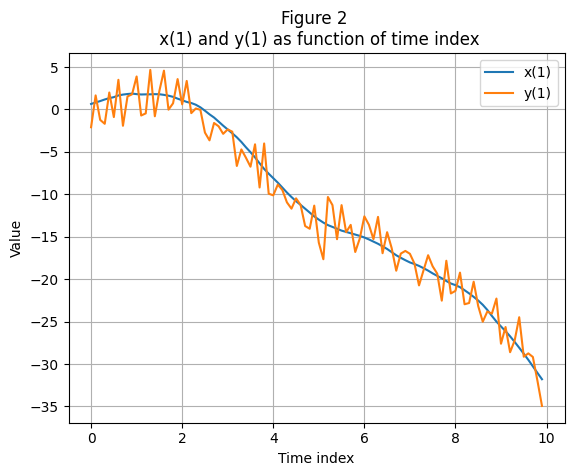

In [98]:
#############################################################################
#            plotting x(1) and y(1) as a function of time index             #  
#############################################################################

t = np.arange(0, N * Ts, Ts)                                       # Create a time array from 0 to 10 seconds, given Ts=0.1 and 100 steps
fig, ax = plt.subplots()                                           # Create a new figure and axis for plotting
ax.plot(t, x_traj[:, 0], label='x(1)')                             # Plot x(1) over time with a label
ax.plot(t, y[:, 0], label='y(1)')                                  # Plot y(1) over time with a label
plt.xlabel('Time index')                                           # Label the x-axis as 'Time index'
plt.ylabel('Value')                                                # Label the y-axis as 'Value'
plt.title('Figure 2 \n x(1) and y(1) as function of time index')   # Set the title with figure number and description
plt.legend()                                                       # Display legend to identify each plot line
plt.grid()                                                         # Add a grid for improved readability
plt.show()                                                         # Display the plot

### Interpretation of **Figure 2**
- **True vs. Measured Values**:  
  The blue line  x(1)  shows the true position, while the orange line y(1)  represents noisy measurements.

- **Measurement Noise**:  
  The orange line fluctuates, showing noise around the true path.

- **Trend**:  
  Both lines follow a downward trend, with measurements aligning generally with the true path.


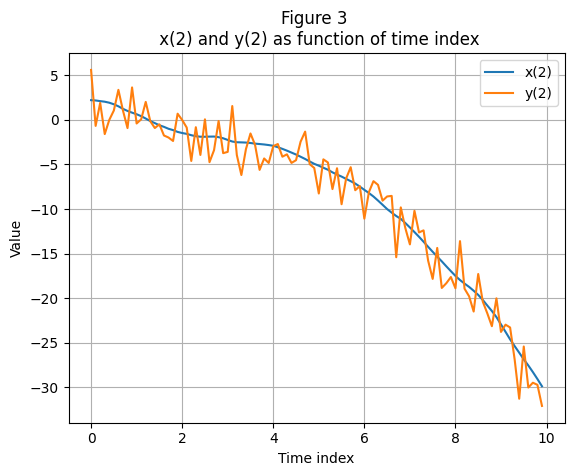

In [99]:
#############################################################################
#            plotting x(2) ad y(2) as a function of time index.             #
#############################################################################

fig, ax = plt.subplots()                                          # Create a new figure and axis for plotting
t = np.arange(0, N * Ts, Ts)                                      # Create a time array from 0 to N*Ts with step Ts
ax.plot(t, x_traj[:, 1], label='x(2)')                            # Plot x(2) over time with a label
ax.plot(t, y[:, 1], label='y(2)')                                 # Plot y(2) over time with a label
plt.xlabel('Time index')                                          # Label the x-axis as 'Time index'
plt.ylabel('Value')                                               # Label the y-axis as 'Value'
plt.title('Figure 3 \n x(2) and y(2) as function of time index')  # Set the title with figure number and description
plt.legend()                                                      # Display legend to identify each plot line
plt.grid()                                                        # Add a grid for improved readability
plt.show()                                                        # Display the plot

### Interpretation of **Figure 3**

- **True vs. Measured Trajectory**:  
  The blue line x(2)  represents the true trajectory, while the orange line  y(2)  indicates measured values affected by noise.

- **Measurement Noise**:  
  The fluctuations in the orange line reflect sensor noise, deviating from the true path.

- **Trend Consistency**:  
  Both trajectories exhibit a similar downward trend, with measured values generally aligning with the true trajectory.


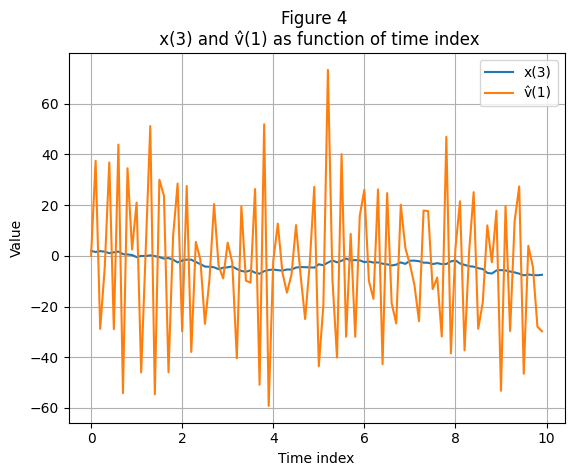

In [100]:
############################################################################
#            plotting x(3) ad v(1) as a function of time index.            #
############################################################################

# The speed is approximated by the derivative with the Euler method

t = np.arange(0, N * Ts, Ts)                                      # Create a time array from 0 to N*Ts with step Ts
fig, ax = plt.subplots()                                          # Create a new figure and axis for plotting
x_3 = x_traj[:, 2]                                                # Extract the third state (x(3)) from the trajectory data
v_1 = v[:, 0]                                                     # Extract the first velocity component (v̂(1)) from the velocity data
ax.plot(t, x_3, label='x(3)')                                     # Plot x(3) over time with a label
ax.plot(t, v_1, label='v̂(1)')                                     # Plot v̂(1) over time with a label
plt.xlabel('Time index')                                          # Label the x-axis as 'Time index'
plt.ylabel('Value')                                               # Label the y-axis as 'Value'
plt.title('Figure 4 \n x(3) and v̂(1) as function of time index')  # Set the title with figure number and description
plt.legend()                                                      # Display legend to identify each plot line
plt.grid()                                                        # Add a grid for improved readability
plt.show()                                                        # Display the plot



### Interpretation of **Figure 3**
- **True vs. Estimated Velocity**: 
  The blue line x(3) represents the true velocity component, while the orange line v(1)  shows the estimated velocity based on noisy measurements.

- **High Variability in Estimates**:  
  The orange line fluctuates significantly, indicating that the estimated velocity is highly affected by measurement noise.

- **Stability of True Velocity**:  
  The blue line remains relatively stable, reflecting the true underlying velocity, while the orange line exhibits spikes and noise.


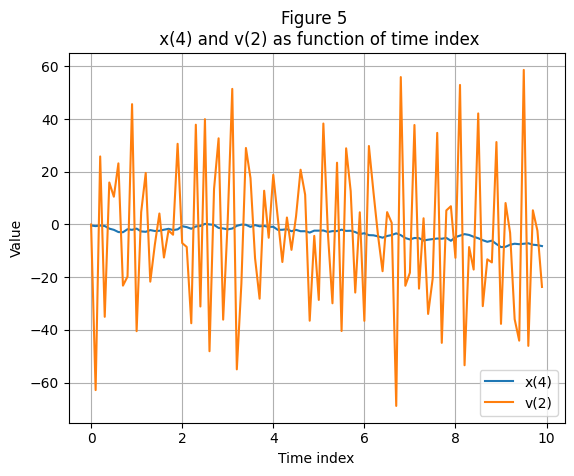

In [101]:
############################################################################
#             plotting x(4) ad v(2) as a function of time index.           # 
############################################################################

t = np.arange(0, N * Ts, Ts)            # Create a time array from 0 to N*Ts with step Ts
fig, ax = plt.subplots()                # Create a new figure and axis for plotting
x_4 = x_traj[:, 3]                      # Extract the fourth state (x(4)) from the trajectory data
v_2 = v[:, 1]                           # Extract the second velocity component (v(2)) from the velocity data
ax.plot(t, x_4, label='x(4)')           # Plot x(4) over time with a label
ax.plot(t, v_2, label='v(2)')           # Plot v(2) over time with a label
plt.xlabel('Time index')                # Set the x-axis label as 'Time index'
plt.ylabel('Value')                     # Set the y-axis label as 'Value'
plt.title('Figure 5 \n x(4) and v(2) as function of time index')  # Set the title with figure number and description
plt.legend()                            # Display legend to identify each plot line
plt.grid()                              # Add a grid for improved readability
plt.show()                              # Show the plot

### Interpretation of **Figure 5**

- **True vs. Estimated Velocity Component**:  
  The blue line x(4)  represents the true value of the second velocity component, while the orange line v(2)  shows the noisy estimated velocity.

- **High Noise in Estimates**:  
  The orange line displays significant fluctuations, indicating a high level of noise in the velocity estimates.

- **Stability of the True Value**:  
  The blue line remains stable, suggesting a consistent true velocity, while the orange line is highly variable due to measurement noise.



             Probleme 3 : Causal Kalman filter

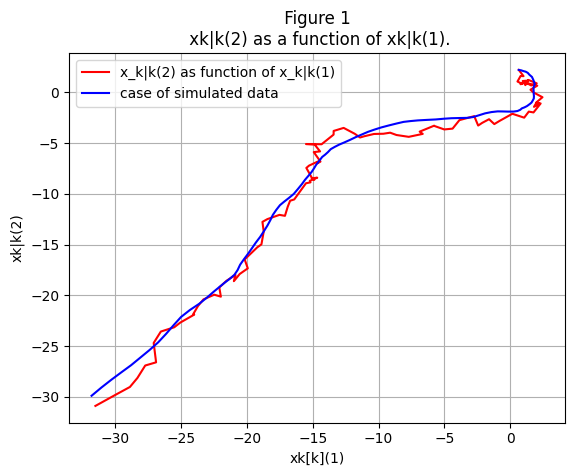

In [102]:
############################################################################
#                   plotting xk|k(2) as a function of xk[k](1).            #    
############################################################################

plt.figure()
plt.plot(x_kalman[:, 0], x_kalman[:, 1], 'r-', label='x_k|k(2) as function of x_k|k(1)') # Plot Kalman-filtered x_k|k(2) vs x_k|k(1) with a red line and label
plt.plot(x_traj[:, 0], x_traj[:, 1], 'b-', label='case of simulated data')               # Plot simulated data x_traj(2) vs x_traj(1) with a blue line and label
plt.xlabel('xk[k](1)')
plt.ylabel('xk|k(2)')
plt.title(' Figure 1 \n xk|k(2) as a function of xk|k(1).')                              # Set the title with figure number and description
plt.legend()                                                                             # Display legend to identify each plot line
plt.grid()                                                                               # Add a grid for improved readability
plt.show()                                                                               # Display the plot

### Interpretation of **Figure 1**:

- **Estimated vs. True Trajectory**:  
  The red line estimated  x_k|k(2)  vs  x_k|k(1)  closely follows the blue line (simulated data), indicating accurate tracking.

- **Minor Deviations**:  
  Small discrepancies between the lines are due to noise, but the filter effectively reduces them.

- **Filter Effectiveness**:  
  This figure shows the Kalman Filter’s accuracy in aligning estimates with the true trajectory.

In [103]:

# define the names and labels for each subplot, and we try to reduce the commands
subplots = [{'name': 'xk(1)', 'ylabel': 'xk|k(1)', 'title': 'xk|k(1) as a function of time index'},
            {'name': 'xk(2)', 'ylabel': 'xk|k(2)', 'title': 'xk|k(2) as a function of time index'},
            {'name': 'xk(3)', 'ylabel': 'xk|k(3)', 'title': 'xk|k(3) as a function of time index'},
            {'name': 'xk(4)', 'ylabel': 'xk|k(4)', 'title': 'xk|k(4) as a function of time index'}]


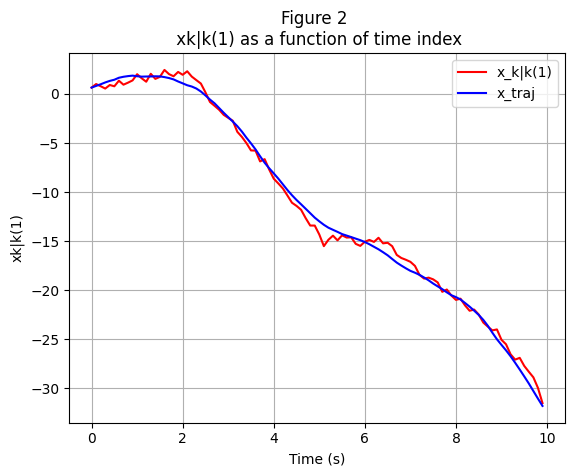

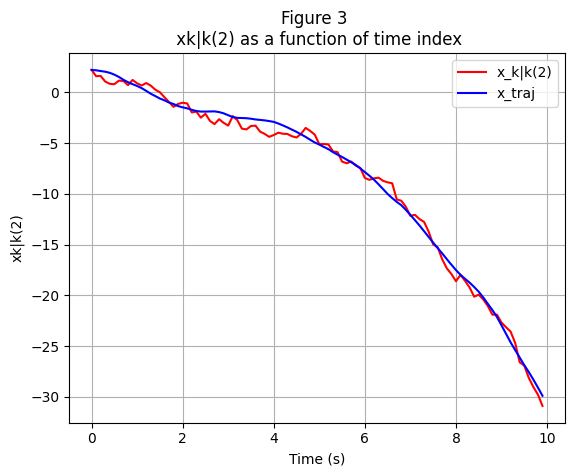

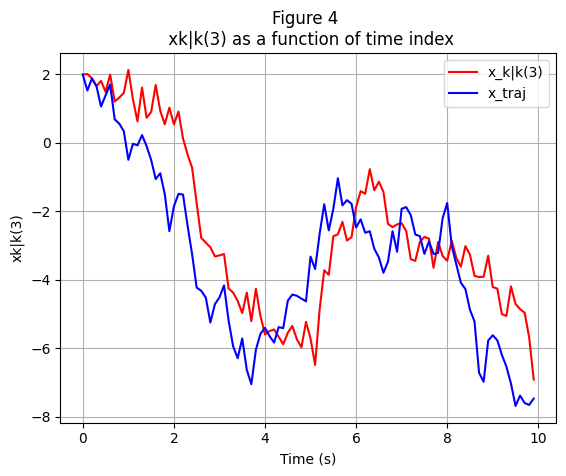

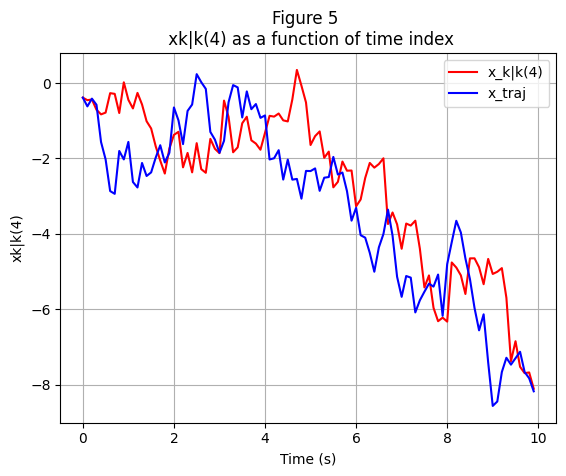

In [104]:
# Loop through the subplots and plot each one
for i, subplot in enumerate(subplots):
    plt.figure(i) 
    t = np.arange(0, N * 0.1, 0.1)                          # Define the time array with intervals of 0.1 seconds
    
    plt.plot(t, x_kalman[:, i], 'r-', label=f'x_k|k({i+1})')  # Plot the Kalman-filtered data for the current state with a red line
    plt.plot(t, x_traj[:, i], 'b-', label='x_traj')           # Plot the true trajectory data for the current state with a blue line
    
    plt.xlabel('Time (s)')                                    # Label the x-axis as 'Time (s)'
    plt.ylabel(subplot['ylabel'])                             # Set the y-axis label from the subplot dictionary
    plt.title(f"Figure {i + 2} \n {subplot['title']}")        # Set the title with the figure number and subplot title
    
    plt.legend()                                              # Display the legend to label each line on the plot
    plt.grid(True)                                            # Add a grid for better readability of the plot
    plt.show()                                                # Show the plot for the current subplot

Interpretation for Figures 2, 3, 4, and 5:

### Figure 2
- **True vs Estimated State x_k|k(1)**:  
  The red line (\( x_{k|k}(1) \)) closely follows the blue line (true trajectory), showing strong alignment.
- **Minor Deviations**:  
  Small fluctuations are present, but the Kalman Filter effectively tracks the trend.

### Figure 3
- **True vs Estimated State  x_k|k(2)**:  
  The estimated trajectory (red) aligns well with the true trajectory (blue), with only slight deviations.
- **Noise Reduction**:  
  The filter reduces noise, resulting in smooth tracking.
- **Trend Consistency**:  
  The downward trend is captured accurately by the filter.

### Figure 4
- **True vs. Estimated Velocity x_k|k(3)**:  
  The red line fluctuates around the true velocity (blue), with some noticeable divergence.
- **Noise Presence**:  
  Variability is higher here, indicating that velocity estimates are more affected by noise.
- **Filter Role**:  
  The Kalman Filter partially smooths the data but shows less accuracy than in position tracking.

### Figure 5
- **True vs. Estimated Velocity x_k|k(4)**:  
  Significant fluctuations in the estimated velocity (red) compared to the true velocity (blue).
- **High Variability**:  
  Greater deviations are visible, suggesting higher noise levels in this velocity component.
- **Need for Smoothing**:  
  This plot underscores the challenge of accurately estimating velocity, with potential room for filter adjustment. 

-       The robust accuracy in tracking position, as shown in Figures 2 and 3.
-       The persistent challenges in accurately estimating velocity, highlighted in Figures 4 and 5.

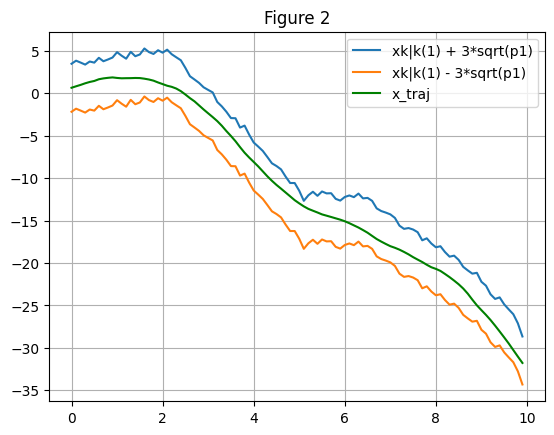

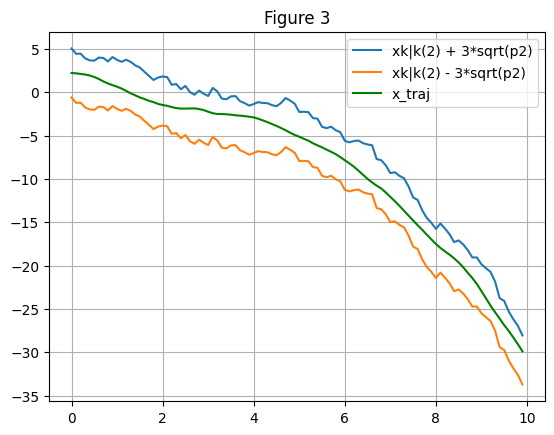

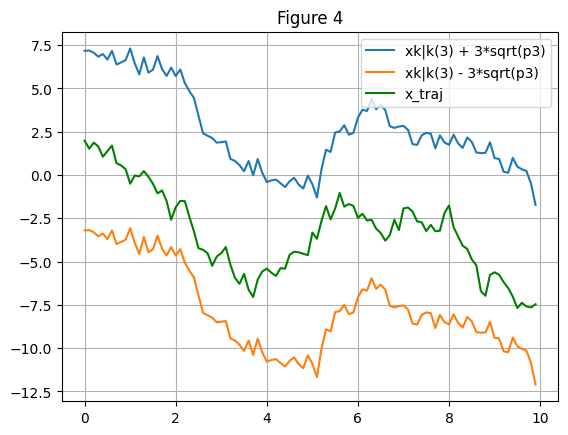

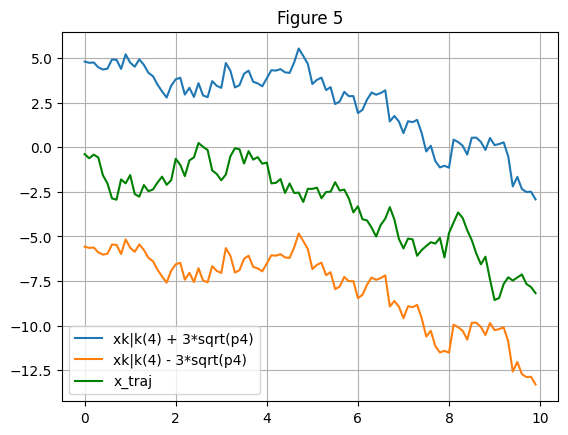

In [105]:
############################################################################
#    plot xk|k(i) + 3*sqrt(pi) and xk|k(i) - 3*sqrt(pi) for all 4 states   # 
############################################################################

for i in range(4):
    t = np.arange(0, N * Ts, Ts)
    plt.figure()
    plt.plot(t, x_kalman[:, i] + 3*np.sqrt(pk[i]), label=f'xk|k({i+1}) + 3*sqrt(p{i+1})')
    plt.plot(t, x_kalman[:, i] - 3*np.sqrt(pk[i]), label=f'xk|k({i+1}) - 3*sqrt(p{i+1})')
    plt.plot(t, x_traj[:, i], 'g-', label='x_traj')
    plt.title(f"Figure {i + 2}")   # Set the title with the figure number
    plt.legend()                   # Display the legend to label each line
    plt.grid()                     # Add grid for better readability
    plt.show()                     # Show the plot


### Interpretation for Figures 2, 3, 4, and 5:

#### Figure 2
- **Position Uncertainty for x_k|k(1)**:  
  The green line shows the true trajectory, while the blue and orange lines represent the upper and lower bounds (±3 standard deviations).
- **Filter Confidence**:  
  The true trajectory largely remains within these bounds, indicating that the filter provides a reasonable confidence interval for position estimates.

#### Figure 3
- **Position Uncertainty for x_k|k(2)**:  
  The green line is the true path, with the blue and orange lines showing the confidence range.
- **Accuracy**:  
  The true position stays mostly within bounds, confirming the filter’s effectiveness in capturing the position within expected uncertainty.

#### Figure 4
- **Velocity Uncertainty for  x_k|k(3)**:  
  The green line reflects the true velocity, while the blue and orange lines represent the confidence interval.
- **Increased Variability**:  
  The velocity estimates show higher deviation, with the true path occasionally nearing the bounds, suggesting more noise in velocity estimates.

#### Figure 5
- **Velocity Uncertainty for x_k|k(4)**:  
  Similar to Figure 4, the true velocity (green) fluctuates within the bounds (blue and orange).
- **High Noise**:  
  The larger variations in bounds indicate greater uncertainty in this velocity component, highlighting the need for further smoothing.

      These figures demonstrate that the Kalman Filter maintains the true values mostly within confidence bounds, though velocity components exhibit higher noise and variability.

             Probleme 4. Smoother filter

In [106]:
# initialize x_smooth and P_smooth
x_smooth = np.zeros((N, 4))
P_smooth = np.zeros((N, 4, 4))
psmooth = np.zeros((N, 4))

# initialize x_smooth and P_smooth at the end of the range
x_smooth[N-1] = x_kalman[N-1]
P_smooth[N-1] = P_kalman[N-1]

# backward pass
for k in range(N-2, -1, -1):    # the data of N=98 is taken from the kalman filter before at this step
    if k == -1:
        x_smooth[-1] = x_kk
        P_smooth[k] = P_kk
    else:
        # Prediction step
        x_kk_1 = A @ x_kalman[k].T
        P_kk_1 = A @ P_kalman[k] @ A.T + q
        
        # Smoothing step
        G_k = P_kalman[k] @ A.T @ np.linalg.inv(P_kk_1)
        x_smooth[k] = x_kalman[k] + G_k @ (x_smooth[k+1] - x_kk_1)
        P_smooth[k] = P_kalman[k] + G_k @ (P_smooth[k+1] - P_kk_1) @ G_k.T
    
    # Extract diagonal elements of P_smooth
    psmooth[k] = np.diagonal(P_smooth[k])    


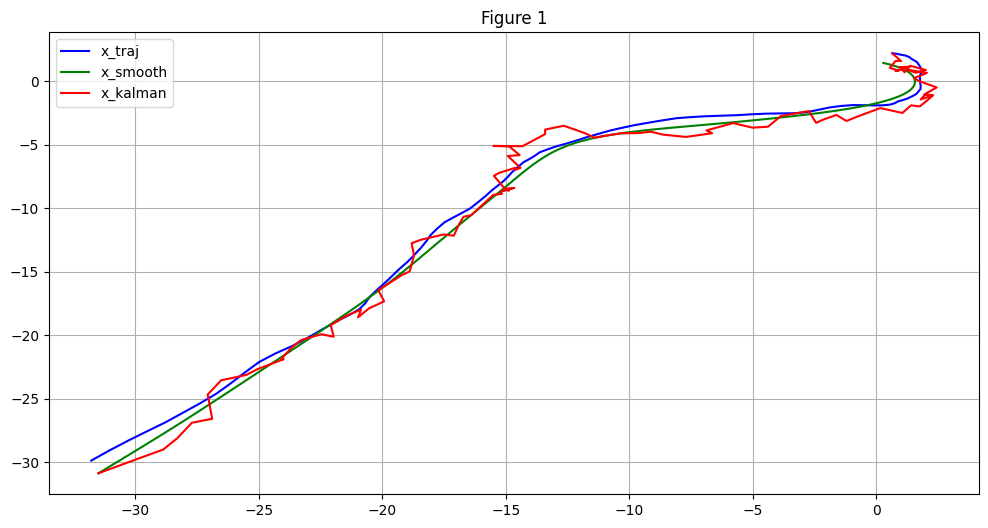

In [107]:
fig, axs = plt.subplots(1, figsize=(12, 6))
x_1 = x_smooth[:, 0]
x_2 = x_smooth[:, 1]  # creates a new variable x_1 that contains all the values in the first column
                      # of the x array. This is useful for plotting x(2) as a function of x(1), since x(1) is in
                      # the first column of x and x(2) is in the second column.
axs.plot(x_traj[:, 0], x_traj[:, 1], 'b-', label='x_traj')
axs.plot(x_1, x_2, 'g-', label='x_smooth')
axs.plot(x_kalman[:, 0], x_kalman[:, 1], 'r-', label='x_kalman')
axs.legend()          # Display the legend to label each line
plt.title("Figure 1") # Set the title with the figure number
plt.grid()            # Add grid for better readability
plt.show()            # Show the plot

Interpretation of **Figure 1**:

- **True Path (Blue)**: The actual object trajectory.

- **Kalman Filter (Red)**: Follows the true path initially but deviates in noisy regions.

- **Kalman Smoother (Green)**: Aligns closely with the true path, especially where the filter diverges, providing a more accurate estimate.

        The smoother effectively refines the noisy Kalman estimates, especially in areas with high noise.

## Implementation of  the smooth Kalman filter  for all 4 states

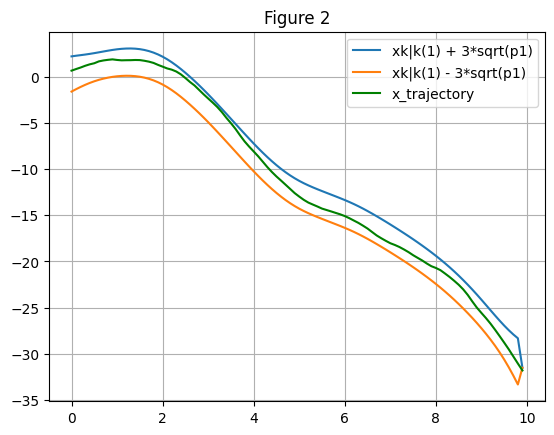

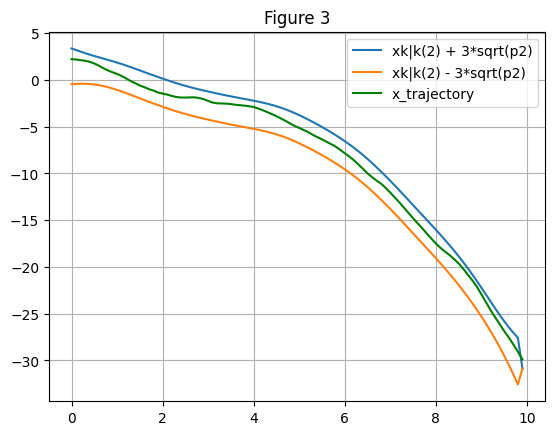

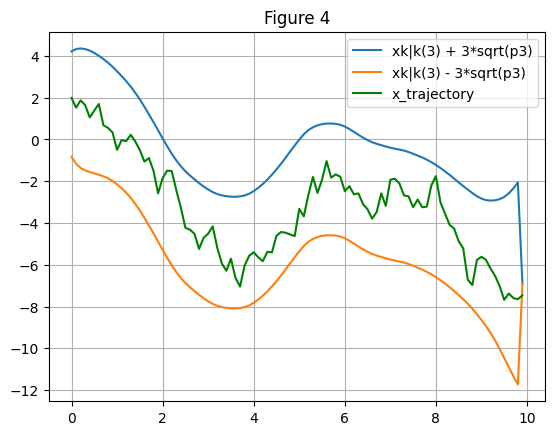

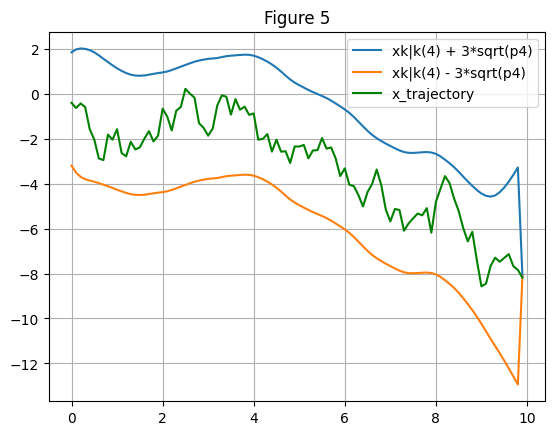

In [108]:
for i in range(4):
    t = np.arange(0, N * Ts, Ts)
    plt.figure()
    plt.plot(t, x_smooth[:, i] + 3 * np.sqrt(psmooth[:, i]), label=f'xk|k({i+1}) + 3*sqrt(p{i+1})')
    plt.plot(t, x_smooth[:, i] - 3 * np.sqrt(psmooth[:, i]), label=f'xk|k({i+1}) - 3*sqrt(p{i+1})')
    plt.plot(t, x_traj[:, i], 'g-', label='x_trajectory') # Plot the true trajectory for comparison
    plt.title(f"Figure {i + 2}")                          # Set the title with the figure number
    plt.grid()                                            # Add grid for better readability
    plt.legend()                                          # Display the legend to label each line
    plt.show()                                            # Show the plot

## Interpretation for Figures 2, 3, 4, and 5:

### Figure 2
- **Position Uncertainty  x_k|k(1)**:  
  The true trajectory (green) mostly stays within the bounds defined by (blue and orange lines), indicating good confidence in the estimate.

### Figure 3
- **Position Uncertainty  x_k|k(2)**:  
  The true path remains largely within the confidence bounds, confirming the filter's accuracy in tracking the second position component.

### Figure 4
- **Velocity Uncertainty  x_k|k(3)**:  
  The green line (true velocity) fluctuates within bounds but shows more variability, suggesting increased noise in velocity estimates.

### Figure 5
- **Velocity Uncertainty x_k|k(4)**:  
  The bounds for the fourth component (blue and orange) are wider, reflecting higher uncertainty, with the true velocity (green) showing frequent fluctuations within these bounds.

      The Kalman Filter provides accurate position estimates, while velocity estimates exhibit greater variability and noise.


# Conclusion :

This lab demonstrated how a Kalman Filter and Smoother can be used for tracking in 2D space, where the real-time estimates of position were significantly better thanks to this filtering process; although there was an escalation with the noise sensitivity when it was about taking some estimations on velocity·

The Kalman smoother smoothed out tracking errors by incorporating future measurements which greatly aligned our filters estimate with true trajectory·

    Making use of these techniques makes us closer than ever to achieving perfectly accurate tracking results upon operating within Noisy environments 